# SENG 474 Data Mining Project
## Google Play Store App Recommendation
------------------------------------------------------------
November 30, 2018

    Michael Baart - V00199818
    Chrisanda Ann - V00811197
    Tal Melamed - V00795078
    


## Introduction

The mobile app market has a very polarized structure, a very small number of the apps hold an overwhelming majority of the market share. This makes it very difficult for less popular apps to gain any market traction as well as for users to find apps that may be appealing to them. Due to the very large number of available apps a data-driven recommendation system is necessary to expose users to new apps that are appealing to them but not in the typical top 100 list. 

Two primary attributes provide a methodology to recommend apps, the users preference and the similarity among apps. This paper will focus on similarity among apps due to what is available in the data set. 


## Related Work

@TODO

## Data Collection

The data set used in this project is the “Google Play Store Apps” available from Kaggle [1]. The data set contains Google Play Store app listings that were web scraped from the Android Market. The data is a available as a CSV file to download. The data set contains 10841 entries with 13 columns. Of 10841 thousand app names 8197 are unique. 

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

data = pd.read_csv('google-play-store-apps/googleplaystore.csv')
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Data Preprocessing

After importing the data set, the columns that won't be required for the mining and recommendation engine are dropped. The size of the app, last updated date, current version number and the android version number do not have an effect on the analysis and on the recommender engine. Hence these columns are dropped. The dataset after this cleanup is shown below.

In [38]:
to_drop = ['Size',
          'Last Updated',
          'Current Ver',
          'Android Ver']
data.drop(to_drop, inplace=True, axis=1)
data.head()


,App,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,"10,000+",Free,0,Everyone,Art & Design
1,Coloring book moana,ART_AND_DESIGN,3.9,967,"500,000+",Free,0,Everyone,Art & Design;Pretend Play
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,"5,000,000+",Free,0,Everyone,Art & Design
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,"50,000,000+",Free,0,Teen,Art & Design
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,"100,000+",Free,0,Everyone,Art & Design;Creativity


### Data Cleanup

The data is initially imported as a raw string object structure, these would need to be converted to the respective data type. Some of the numberical data from the data set contained charecters like "&" and "+". As part of the mining process, the data was cleaned by removing inconsistent rows, invalid characters and by converting string numbers to numeric values to allow for numerical analysis. Rows missing a value or containing Nan values are removed. The data after cleanup is shown below.

In [39]:
def clean_data(data):
    # Fixing Price
    data = data.where(data['Price'] != "Everyone")
    data["Price"] = data["Price"].str.replace("$", '')
    data["Price"] = pd.to_numeric(data["Price"])

    # Fixing Installs
    data["Installs"] = data["Installs"].str.replace(",", '')
    data["Installs"] = data["Installs"].str.replace("+", '')
    data["Installs"] = pd.to_numeric(data["Installs"])

    data["Reviews"] = pd.to_numeric(data["Reviews"])
    data['Genres'] = data['Genres'].fillna('')
    
    data = data.dropna()
        
    return data

data = clean_data(data)

# data['AG'] = data[['App', 'Genres']].apply(lambda x: ''.join(x), axis=1)
# data["AppName_Genres"] = data["App"].map(str) + " - " + data["Genres"]
data.head()

,App,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,10000.0,Free,0.0,Everyone,Art & Design
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,5000000.0,Free,0.0,Everyone,Art & Design
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,50000000.0,Free,0.0,Teen,Art & Design
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,100000.0,Free,0.0,Everyone,Art & Design;Creativity


## Visualization

Various visualization are produced to provide insight into the properties of the data.

In [40]:
def count_unique(col):
    unique, counts = np.unique(col, return_counts=True)
    return np.array(list(zip(unique, counts)), dtype=object)

def plot_bar(col, title, color=None):
    category = count_unique(col)
    fig, ax = plt.subplots(figsize=(18,8))
    y_pos = np.arange(len(category[:,0]))
    plt.bar(y_pos, category[:,1], color=color)
    plt.xticks(y_pos, category[:, 0])
    plt.xticks(rotation=75)
    fig.suptitle(title, fontsize=20)
    
def plot_pie(col, title, color=None):
    category = count_unique(col)
    fig, ax = plt.subplots(figsize=(8,8))
    plt.pie(category[:,1], autopct='%.2f%%', labels=category[:,0])
    fig.suptitle(title, fontsize=20)
    
X = data.values

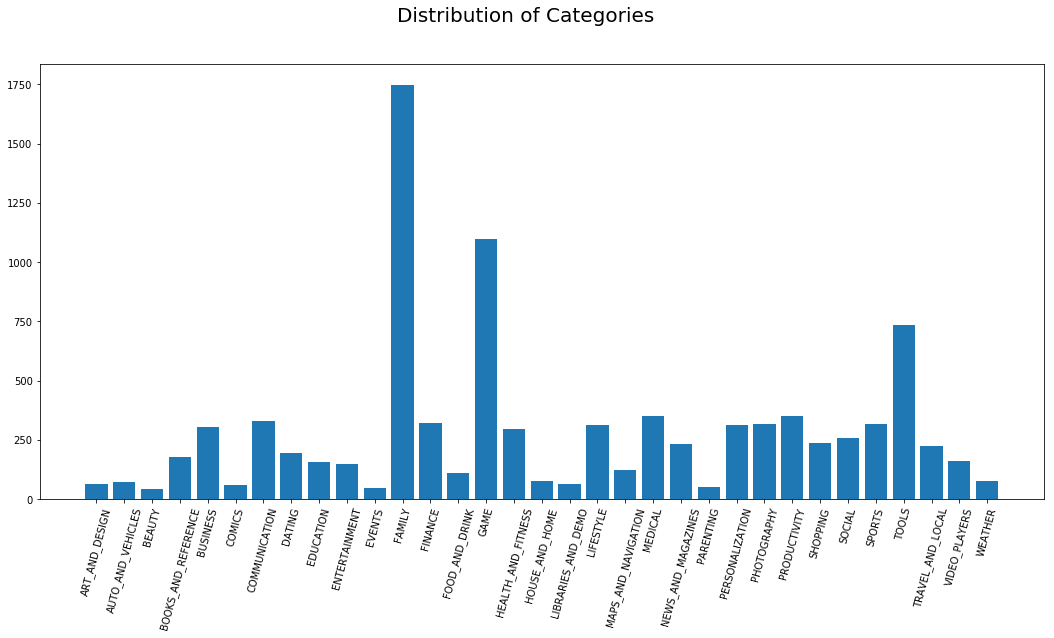

In [41]:
plot_bar(X[:, 1], 'Distribution of Categories')

The data set contains 33 app categories with a very uneven distribution of contents. The categories FAMILY, GAME, and TOOLS make up a large portion of all the apps.

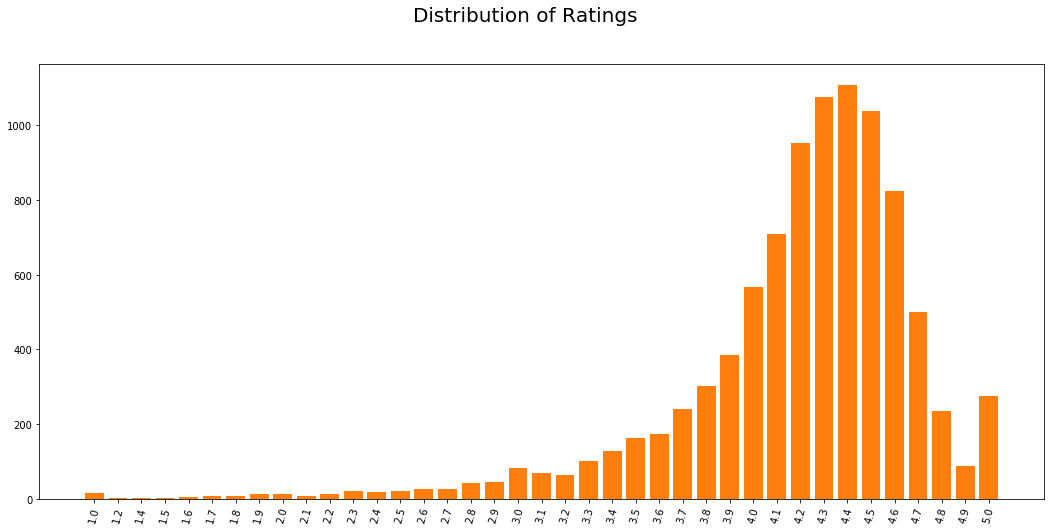

In [42]:
plot_bar(X[:, 2], 'Distribution of Ratings', 'C1')

The ratings distribution is a Bell Curve like shape that is centered around the 4.4 star value. It is interesting to see that nearly all app ratings reside between the 3.0 and 5.0 value. An app rating of 4.1 would initially appear to be a well recieved app, but that is actually a below average score.

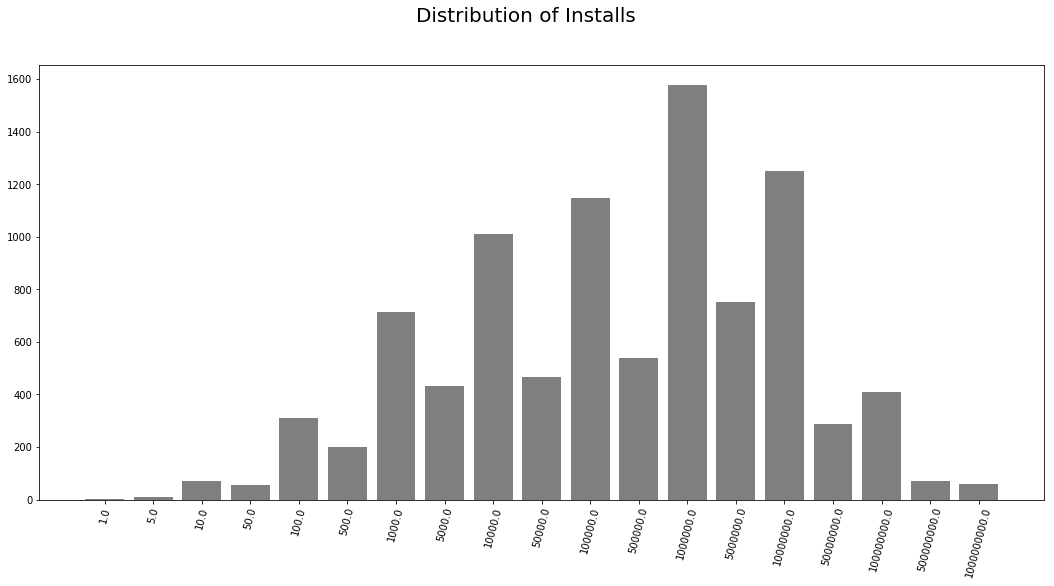

In [43]:
plot_bar(X[:, 4], 'Distribution of Installs', 'C7')

Install labeling follows an exponential growth leading to the strange looking graph pattern. However the insight can still be made that the majority of the applications in our data set are of very popular applications with large install bases.

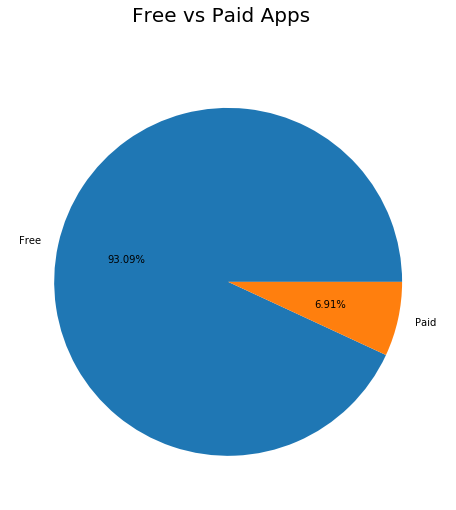

In [44]:
plot_pie(X[:, 5], 'Free vs Paid Apps', 'C2')

An overwhelming majority of the application in the Google Play Store are of free download.

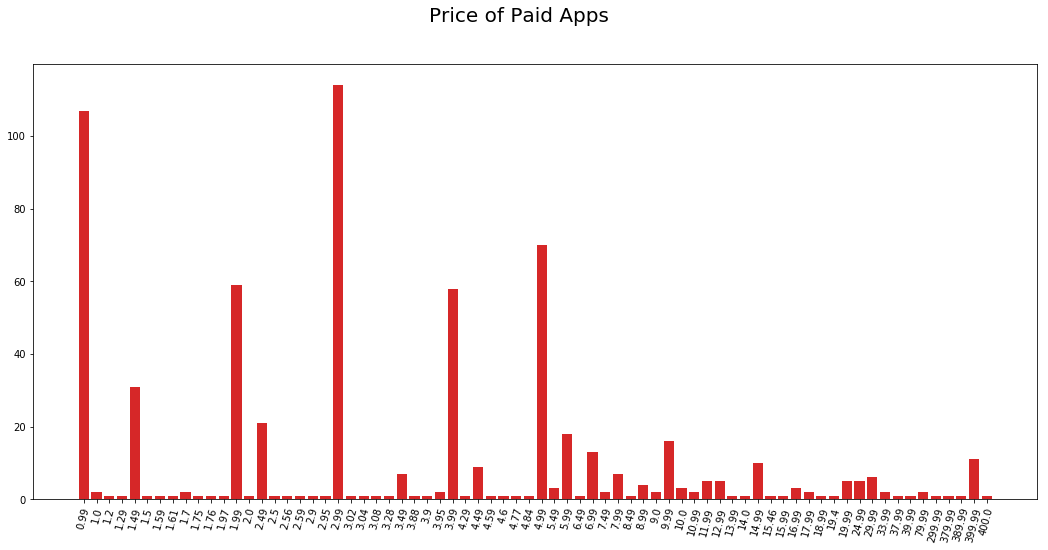

In [45]:
plot_bar(X[X[:, 6]>0][:, 6], 'Price of Paid Apps', 'C3')

Of the apps that are not free their prices have a sporadic distribution with particular emphasis on x.99 value points. Interesting that $399.99 is very popular price point in its local bracket.

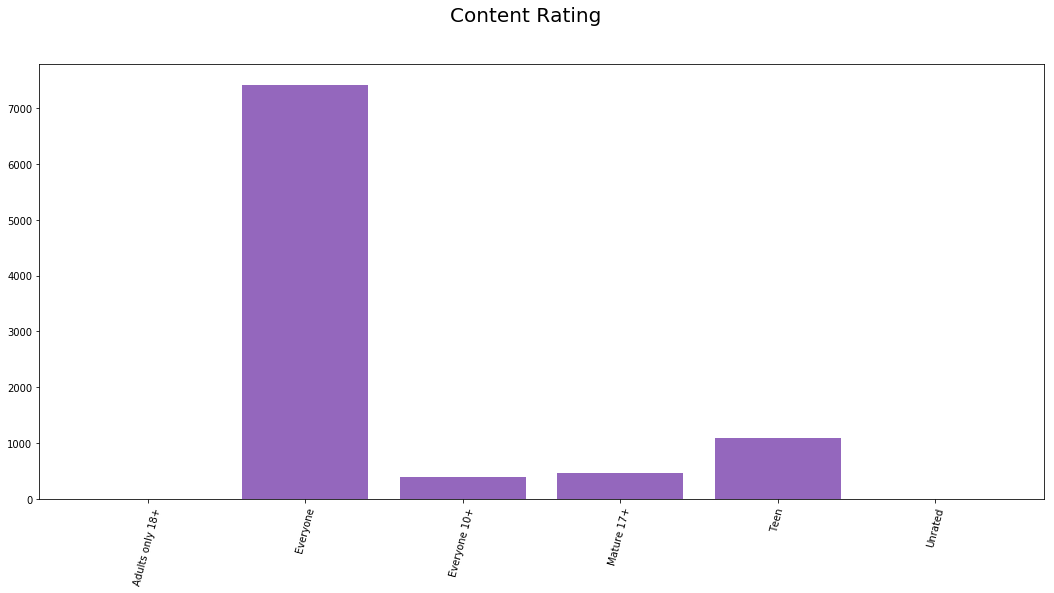

In [46]:
plot_bar(X[:, 7], 'Content Rating', 'C4')

The content rating is overwhelmingly family friendly.

### Observations

The data collected is largely of well recieved, popular apps in a wide range of categories and price points. The data seems biased towards popular and well available apps, as I believe there are many poorly recieved, unpopular apps that did not make this data set. Therefore, the data set is not fully representative of the Google Play Store App environment, however for the purposes of our analysis this data set is satisfactory. It is likely that a recommendation system would only recommend popular, well received apps to its users.

## Data Mining

### Genres Based Recommender System

For providing an app recommendation, the similarity between apps based on a certain metric is computed. For this recommendation system the main metric used is the "Genre" of the app. Content based filtering is done on the dataset to retrieve apps that are most similar to each other based on Genre. 

### TF-IDF Matrix

A fitted term frequency–inverse document frequency is generated for the apps' generes. The vocabulary set for the dataset can be seen below.


In [47]:
# GENRE BASED RECOMMENDER
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(data['Genres'])

print(tf.vocabulary_)


{'art': 10, 'design': 44, 'art design': 11, 'pretend': 115, 'play': 108, 'design pretend': 46, 'pretend play': 116, 'creativity': 41, 'design creativity': 45, 'auto': 14, 'vehicles': 147, 'auto vehicles': 15, 'beauty': 16, 'books': 21, 'reference': 126, 'books reference': 22, 'business': 25, 'comics': 37, 'comics creativity': 38, 'communication': 39, 'dating': 42, 'education': 51, 'education education': 55, 'education creativity': 54, 'music': 95, 'video': 148, 'education music': 56, 'music video': 98, 'action': 0, 'adventure': 3, 'education action': 52, 'action adventure': 2, 'education pretend': 57, 'brain': 23, 'games': 78, 'education brain': 53, 'brain games': 24, 'entertainment': 64, 'entertainment music': 69, 'entertainment brain': 66, 'entertainment creativity': 67, 'events': 71, 'finance': 72, 'food': 76, 'drink': 47, 'food drink': 77, 'health': 79, 'fitness': 73, 'health fitness': 80, 'house': 82, 'home': 81, 'house home': 83, 'libraries': 84, 'demo': 43, 'libraries demo': 85,

The inverse document frequency can be seen here

In [48]:
txt_fitted = tf.fit(data['Genres'])
idf = tf.idf_
print(dict(zip(txt_fitted.get_feature_names(), idf)))
tfidf_matrix.shape

{'action': 3.942412636021208, 'action action': 7.254576395312966, 'action adventure': 5.232293267473079, 'adventure': 4.788361878537119, 'adventure action': 7.505890823593872, 'adventure brain': 9.451800972649185, 'adventure education': 9.046335864541021, 'arcade': 4.733302101354091, 'arcade action': 7.372359430969349, 'arcade pretend': 9.451800972649185, 'art': 5.955293411182705, 'art design': 5.955293411182705, 'audio': 9.451800972649185, 'audio music': 9.451800972649185, 'auto': 5.840883060004961, 'auto vehicles': 5.840883060004961, 'beauty': 6.383748037515568, 'board': 6.03407428903582, 'board action': 8.758653792089241, 'board brain': 7.372359430969349, 'board pretend': 9.451800972649185, 'books': 4.946451121943305, 'books reference': 4.946451121943305, 'brain': 5.896452911159772, 'brain games': 5.896452911159772, 'business': 4.427920451802908, 'card': 6.253127855098504, 'card action': 9.046335864541021, 'card brain': 9.451800972649185, 'casino': 6.5073619934827445, 'casual': 4.57

(9366, 152)

### Similarity Scores

With the TF-IDF matrix, similarity scores for the recommendation were calculated. For this project the cosine similarity scoring was used. 

In [49]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

array([1.        , 0.61225229, 1.        , ..., 0.        , 0.        ,
       0.        ])

By doing so, we now have a pairwise cosine similarity matrix for all the apps in the dataset.

The function `get_recommendation` uses the calculated similarity scores to get top 50 recommendations for the given app name by getting a sorted list of the similarity scores and mapping them to the apps by indices. 

These 50 recommended apps are then ranked based on their ratings and reviews by the `ranked_recommendation` function that implements a Bayesian  estimate to finally return the top 100 recommended apps for the given app.

In [52]:
data = data.reset_index()
indices = pd.Series(data.index, index=data['App'])


def get_recommendations(app_name):
    idx = indices[app_name]
    if isinstance(idx, np.int64):
        sim_scores = list(enumerate(cosine_sim[idx]))
    else:
        sim_scores = []
        for idx in idx:
            sim_scores.extend(list(enumerate(cosine_sim[idx])))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:50]
    app_indices = [i[0] for i in sim_scores]
    new = data.iloc[app_indices]
    return ranked_recommendations(new)


def ranked_recommendations(recommended_data):
    C = recommended_data['Rating'].mean()
    m = recommended_data['Reviews'].quantile(0.10)
    final_apps = recommended_data.copy().loc[data['Reviews'] >= m]
    final_apps.shape
    
    def weighted_rating(x, m=m, C=C):
        v = x['Reviews']
        R = x['Rating']
        return (v /(v + m) * R) + (m / (m + v) * C)

    final_apps['score'] = final_apps.apply(weighted_rating, axis=1)
    final_apps = final_apps.sort_values('score', ascending=False)

    return final_apps



## Results


In [53]:
# get_recommendations('German Vocabulary Trainer').head(100)
get_recommendations('Facebook').head(100)

,level_0,index,App,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres,score
2432,2432,2571,Amino: Communities and Chats,SOCIAL,4.8,1259075.0,1.000000e+07,Free,0.0,Teen,Social,4.798304
2413,2413,2552,Pinterest,SOCIAL,4.6,4305441.0,1.000000e+08,Free,0.0,Teen,Social,4.599729
2422,2422,2561,Who Viewed My Facebook Profile - Stalkers Visi...,SOCIAL,4.6,271445.0,5.000000e+06,Free,0.0,Everyone,Social,4.595779
2423,2423,2562,"Hide Something - Photo, Video",SOCIAL,4.6,225103.0,5.000000e+06,Free,0.0,Everyone,Social,4.594928
2430,2430,2569,SPARK - Live random video chat & meet new people,SOCIAL,4.6,79658.0,5.000000e+06,Free,0.0,Mature 17+,Social,4.586202
2419,2419,2558,Telegram X,SOCIAL,4.6,70616.0,5.000000e+06,Free,0.0,Teen,Social,4.584550
2434,2434,2573,Meet – Talk to Strangers Using Random Video Chat,SOCIAL,4.6,60562.0,5.000000e+06,Free,0.0,Mature 17+,Social,4.582176
2424,2424,2563,Love Sticker,SOCIAL,4.6,33177.0,1.000000e+06,Free,0.0,Everyone,Social,4.569353
2436,2436,2575,"💘 WhatsLov: Smileys of love, stickers and GIF",SOCIAL,4.6,22098.0,1.000000e+06,Free,0.0,Everyone,Social,4.556769
2406,2406,2545,Instagram,SOCIAL,4.5,66577313.0,1.000000e+09,Free,0.0,Teen,Social,4.499990


## Evaluation
### Data
The dataset contains around 10000 rows of data with 14 columns of information: App, Category, Rating, Reviews, Size, Installs, Type, Price, Content Rating, Genres, Last Updated, Current Ver, Android Ver. This is a relatively small sample when you think of the large scale data google collects from its many users and apps. The information availible to us does not well distinguish the apps from eachother. There is more emfasis towards stats ie: installs, rating, ranking, last update etc... which are great for ranking the suggestions. The only subjective information we have is the app name and category/genre for determining similarites. 
### Algorithm
Our algorithm produces a good result with our limited dataset. Using genre as the only score for similarities, we still produce relevant suggestions. Unfortunately these suggestion are quite similar for any app in the same genre. We could enhance our results by using key words from each app's name in combination with the genres for some similarity score. We were unsuccessful in using the app name because of a bug regarding numbers in the app's names. Even when removing all the numbers the bug was still occuring. 
### Next time
I think if we were to attempt this again, we would focus more time into selecting a stronger dataset. In our case, if the data contained a copy of the description of each of the apps we could have based our score off of similarities in the descriptions. This would have produced a more accureate result. 

## Conclusion
Our algorithm makes appropriate suggestions. Comparing the similar apps suggested by google playstore with the recommendations we make for Facebook.
![image.png](https://github.com/mbaart/DataExploration/playstore_recommendations.png)
Both google playstore and our algorithm recommend some of the same apps, such as Facebook Lite, Instagram, Snapchat, tumblr, pintrest, and LinkedIn. Without having tried the other apps in the list, they seem appropriate for a social app like Facebook; The rest of our list contains many instant messenger, video chat and free texting type apps. Considering that google has vast stores of data and is capable of far more complex mining algorithms, our algorithm produces a good quality result.

## References

[1] https://www.kaggle.com/lava18/google-play-store-apps#googleplaystore_user_reviews.csv
